In [32]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from math import floor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


Leemos el dataset

In [2]:
df = pd.read_csv("data/PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.shape

(6362620, 11)

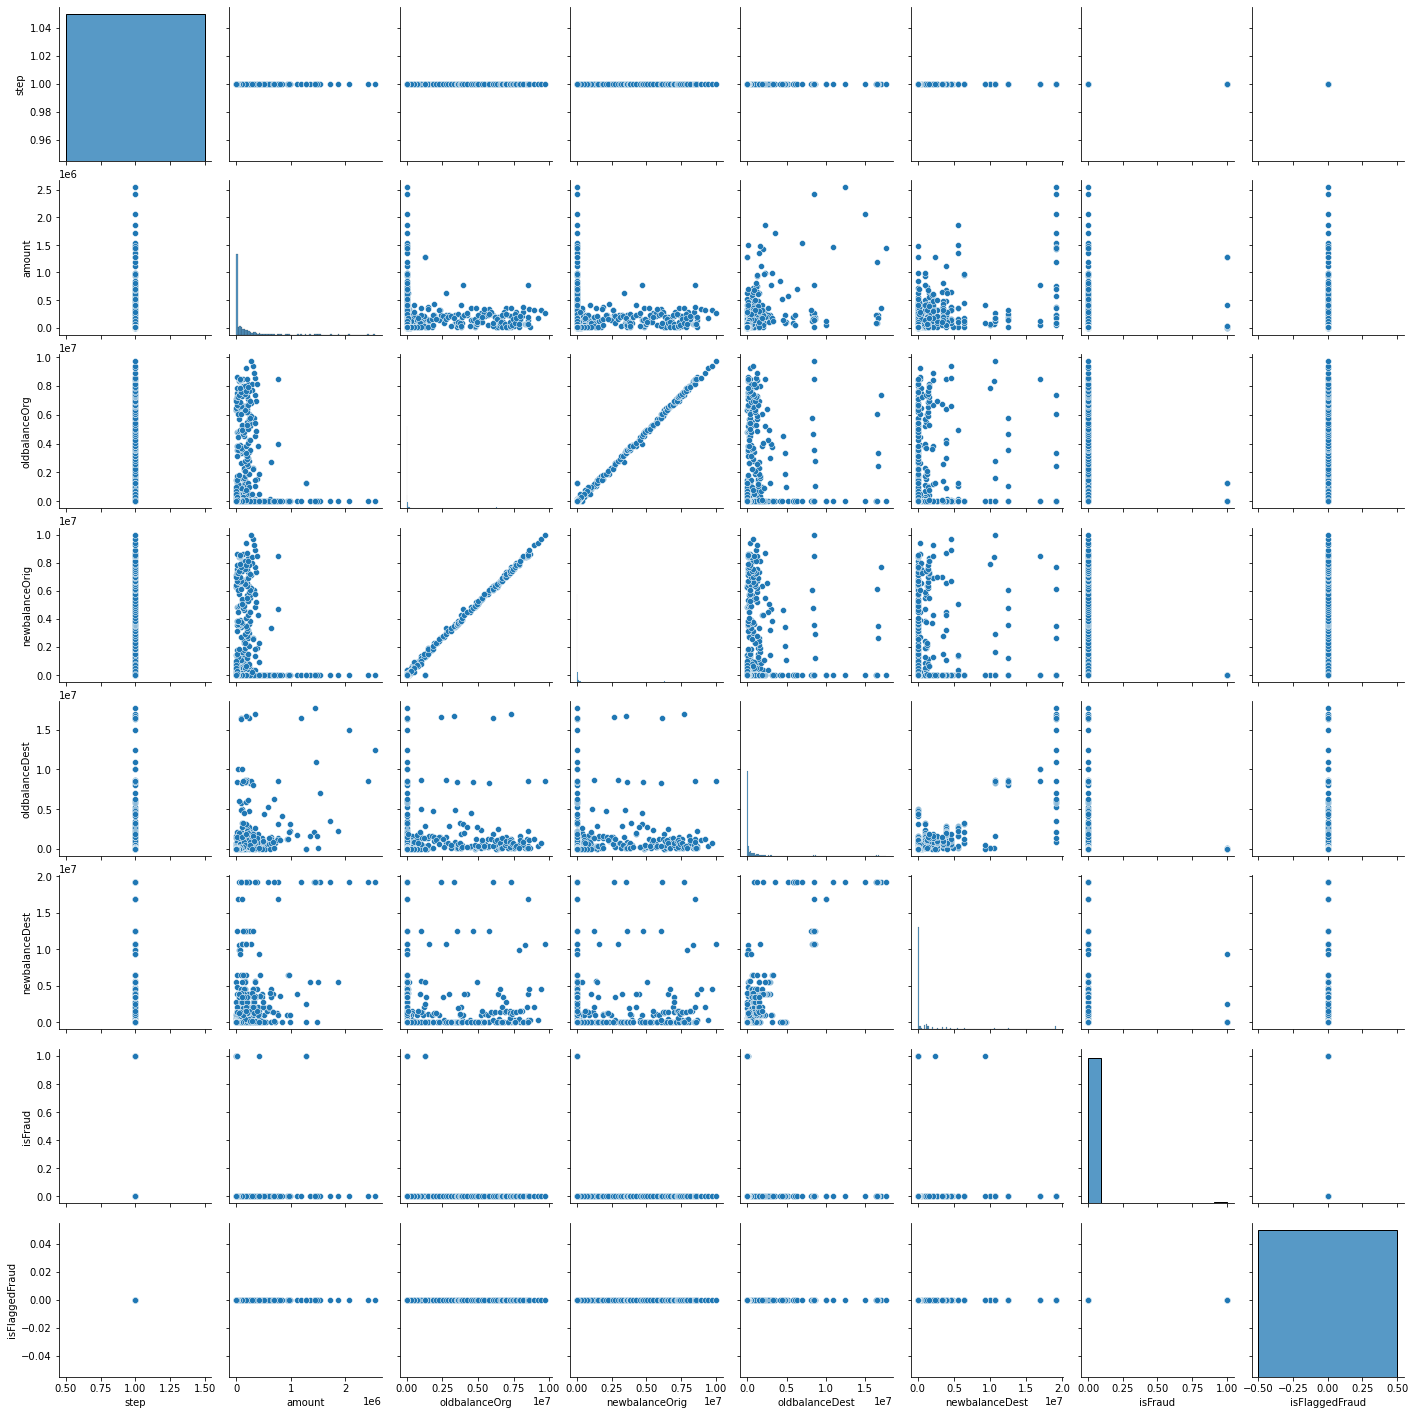

In [4]:
sns.pairplot(df[:1000])

Análisis de las variables

The below column reference:

step: represents a unit of time where 1 step equals 1 hour
type: type of online transaction
amount: the amount of the transaction
nameOrig: customer starting the transaction
oldbalanceOrg: balance before the transaction
newbalanceOrig: balance after the transaction
nameDest: recipient of the transaction
oldbalanceDest: initial balance of recipient before the transaction
newbalanceDest: the new balance of recipient after the transaction
isFraud: fraud transaction

In [5]:
var = np.std(df, axis=0)**2
var

/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


step              2.025839e+04
amount            3.646447e+11
oldbalanceOrg     8.341944e+12
newbalanceOrig    8.550058e+12
oldbalanceDest    1.155442e+13
newbalanceDest    1.349922e+13
isFraud           1.289154e-03
isFlaggedFraud    2.514681e-06
dtype: float64

In [6]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
len(df['nameOrig'].unique())

6353307

In [9]:
len(df['nameDest'].unique())

2722362

Saco la primer letra de los nombres

In [10]:
df['nameOrig'] = df['nameOrig'].astype(str).str[1:]

In [11]:
df['nameDest'] = df['nameDest'].astype(str).str[1:]

Verifico que sean números

In [12]:
df['nameOrig'].astype(str).astype(int)
df['nameDest'].astype(str).astype(int)

0          1979787155
1          2044282225
2           553264065
3            38997010
4          1230701703
              ...    
6362615     776919290
6362616    1881841831
6362617    1365125890
6362618    2080388513
6362619     873221189
Name: nameDest, Length: 6362620, dtype: int64

Puedo agregar dimensiones para cada uno de esos valores asi no favorezco a ninguno por tener un valor mayor

In [13]:
df = pd.get_dummies(df, columns=['type']) 
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,1231006815,170136.00,160296.36,1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,1666544295,21249.00,19384.72,2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,1305486145,181.00,0.00,553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,840083671,181.00,0.00,38997010,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,2048537720,41554.00,29885.86,1230701703,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,786484425,339682.13,0.00,776919290,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,1529008245,6311409.28,0.00,1881841831,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,1162922333,6311409.28,0.00,1365125890,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,1685995037,850002.52,0.00,2080388513,0.00,0.00,1,0,0,0,0,0,1


In [14]:
df =  df[df.columns.drop('isFlaggedFraud')]

Vemos que las clases están desbalanceadas

In [15]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Defino X e y

In [41]:
y = df['isFraud']
X = df[df.columns.drop('isFraud')]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train.shape, X_test.shape

((4262955, 13), (2099665, 13))

newBalanceOrg y newBalanceDest se relacionan con oldBalanceOrg y oldBalanceDest y amount por lo que las suprimo

In [43]:
X_train =  X_train[X_train.columns.drop('newbalanceDest')]
X_train =  X_train[X_train.columns.drop('newbalanceOrig')]
X_test =  X_test[X_test.columns.drop('newbalanceDest')]
X_test =  X_test[X_test.columns.drop('newbalanceOrig')]

In [19]:
X_test.isna().sum()

step              0
amount            0
nameOrig          0
oldbalanceOrg     0
nameDest          0
oldbalanceDest    0
type_CASH_IN      0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64

In [20]:
X_train.isna().sum()

step              0
amount            0
nameOrig          0
oldbalanceOrg     0
nameDest          0
oldbalanceDest    0
type_CASH_IN      0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64

In [21]:
y_train.isna().sum()

0

In [22]:
y_test.isna().sum()

0

Oversampling

In [23]:
from imblearn.over_sampling import RandomOverSampler
oversampler=RandomOverSampler(sampling_strategy='minority');
X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);
print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0    4257463
1    4257463
Name: isFraud, dtype: int64

Composición del test set:
0    2096944
1       2721
Name: isFraud, dtype: int64


Learning..

In [65]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 23, class_weight = {0: 0.2, 1:1})

In [66]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 1}, random_state=23)

In [ ]:
rf.fit(X_train_os, y_train_os)

In [61]:
# Utilizamos el método de predicción en los datos de prueba
predictions = rf.predict(X_test)

In [43]:
predictions.sum()

2857.100000000001

In [47]:
def label_prediction(prediction):
    f = floor(prediction)
    d = prediction - f

    if d > 0.5:
        return 1
    
    return 0

In [59]:
p = np.array([label_prediction(n) for n in predictions])

In [61]:
p.sum()

1429

In [62]:
# Calcular los errores absolutos
errores = abs(predictions - y_test)

# Imprime el error absoluto medio (mae)
print('Error absoluto medio:', round(np.mean(errores), 2))

Error absoluto medio: 0.0


In [57]:
errores.sum()

2096944

In [63]:
# Calcular el error medio porcentual absoluto (MAPE)
mape = 100 * (errores / y_test)
# Calcular y mostrar la precisión
precisión = 100 - np.mean(mape)
print('Precisión:', round(precisión, 2), '%.')

Precisión: 0.0 %.


In [64]:
confusion_matrix(y_test, predictions)

array([[2096944,       0],
       [   2721,       0]])

In [52]:
rf.score(X_test, y_test)

0.0012959210159715954

In [70]:
accuracy_score(y_test, p)

0.9989626916674803

In [38]:
# Saca un árbol del bosque
tree = rf.estimators_[5]
print('La profundidad de este árbol es:', tree.tree_.max_depth)


La profundidad de este árbol es: 59


Logistic regresion

In [73]:
model = LogisticRegressionCV(class_weight = 'balanced')
scaler=StandardScaler()
X_train_sc=scaler.fit_transform(X_train);
X_test_sc=scaler.transform(X_test);

model.fit(X_train_sc,y_train)
y_pred = model.predict(X_test_sc)



/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


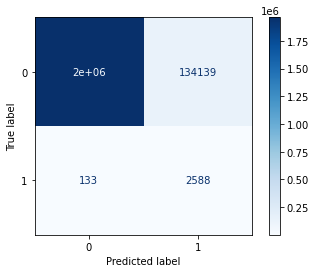

In [75]:
pred_probas = model.predict_proba(X_test_sc);
plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

In [76]:
precision, recall,threshold=precision_recall_curve(y_test,pred_probas[:,1]);


In [78]:
print('Area bajo la curva ROC:',roc_auc_score(y_test,pred_probas[:,1]))

print('Area bajo la curva Precision-Recall:',auc(recall,precision))


Area bajo la curva ROC: 0.9815906193587864
Area bajo la curva Precision-Recall: 0.15849222738007568
